#**Twitter Sentimental Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Libraries and Preprocess Dataset

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the Sentiment140 dataset
data_path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"  # Replace with your file path
df = pd.read_csv(data_path, encoding="latin-1", names=["target", "id", "date", "flag", "user", "text"])

# Keep relevant columns and clean labels
df = df[["target", "text"]]
df['target'] = df['target'].replace({0: 0, 4: 1})  # Map 0 = Negative, 4 = Positive

# Clean tweet text
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\S+", "", tweet)  # Remove mentions
    tweet = re.sub(r"#[A-Za-z0-9]+", "", tweet)  # Remove hashtags
    tweet = re.sub(r"[^A-Za-z0-9 ]+", "", tweet)  # Remove special characters
    return tweet.lower().strip()

df['cleaned_text'] = df['text'].apply(clean_tweet)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['target'], test_size=0.2, random_state=42)


#Tokenize and Pad Sequences

In [ ]:
# Tokenize and pad sequences
max_features = 20000  # Vocabulary size
max_len = 50          # Maximum tweet length

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)


#Build LSTM Model with Attention Mechanism

In [ ]:
# Define key parameters
max_len = 50  # Maximum length of sequences (set this according to your data preprocessing)
max_features = 20000  # Vocabulary size (set this to match your tokenizer vocabulary)

# Input layer
input_layer = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=max_features, output_dim=128, input_length=max_len)(input_layer)

# LSTM layer with sequences
lstm_output, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(embedding)

# Attention mechanism: Self-attention
attention_output = Attention()([lstm_output, lstm_output])  # Self-attention mechanism

# Context vector: Reduce dimensions
context_vector = GlobalAveragePooling1D()(attention_output)

# Add a Dense layer for binary classification
output = Dense(1, activation='sigmoid')(context_vector)

# Define and compile the model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      2,560,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 128),      │        131,584 │ embedding[0][0]        │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 50, 128)        │              0 │ lstm[0][0], lstm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ attention[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            129 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,691,713 (10.27 MB)

 Trainable params: 2,691,713 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(X_train_padded.shape)
print(y_train.shape)


(1280000, 50)
(1280000,)


#Train the Model

Epoch 1/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1668s 370ms/step - accuracy: 0.7691 - loss: 0.4710 - val_accuracy: 0.8158 - val_loss: 0.4051
Epoch 2/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1686s 367ms/step - accuracy: 0.8245 - loss: 0.3893 - val_accuracy: 0.8220 - val_loss: 0.3930
Epoch 3/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1704s 367ms/step - accuracy: 0.8373 - loss: 0.3655 - val_accuracy: 0.8234 - val_loss: 0.3933
Epoch 4/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1642s 365ms/step - accuracy: 0.8476 - loss: 0.3471 - val_accuracy: 0.8212 - val_loss: 0.3996
Epoch 5/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1750s 376ms/step - accuracy: 0.8569 - loss: 0.3289 - val_accuracy: 0.8226 - val_loss: 0.4016


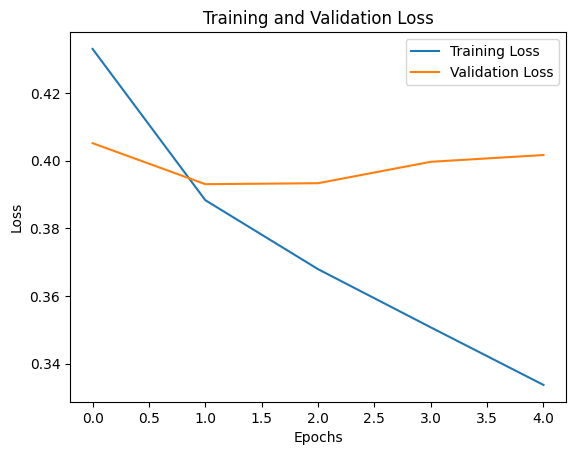

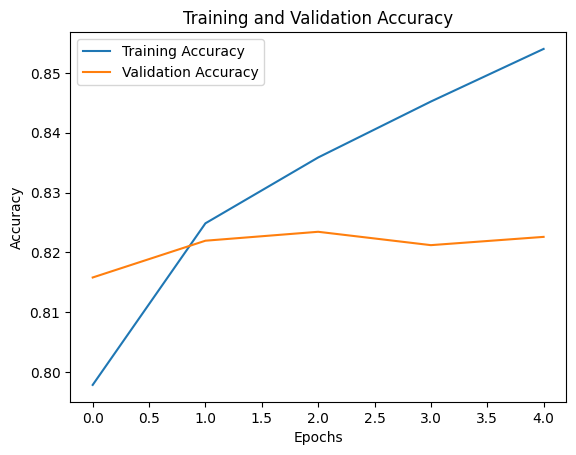

In [ ]:
# Train the model
history = model.fit(
    X_train_padded, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.1
)

import matplotlib.pyplot as plt
# Plot training & validation loss and accuracy
# Access the training history
history_dict = history.history

# Plot Loss
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Extract Embeddings for t-SNE

In [ ]:
# Extract attention weights
import tensorflow as tf
from tensorflow.keras.models import Model
attention_model = Model(inputs=model.input, outputs=[attention_output])
attention_weights = attention_model.predict(X_test_padded[:500])  # Use a subset for t-SNE


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


#Apply t-SNE for Visualization

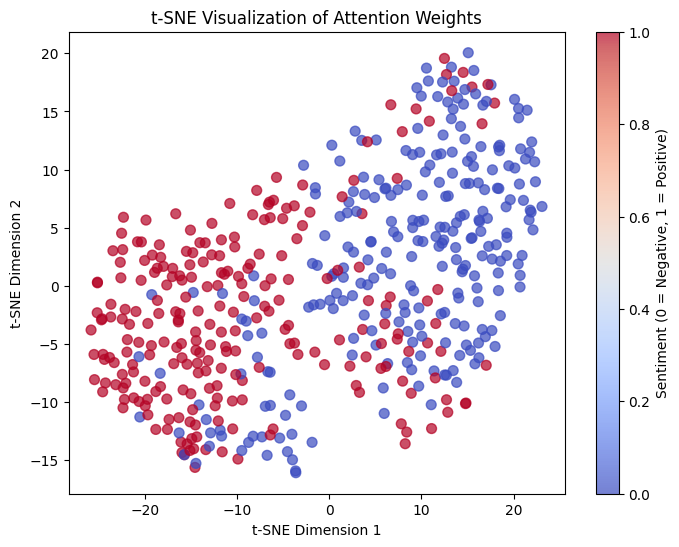

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten attention weights for t-SNE
attention_flat = attention_weights.reshape(attention_weights.shape[0], -1)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
attention_2d = tsne.fit_transform(attention_flat)

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(attention_2d[:, 0], attention_2d[:, 1], c=y_test[:500], cmap='coolwarm', s=50, alpha=0.7)
plt.colorbar(label='Sentiment (0 = Negative, 1 = Positive)')
plt.title("t-SNE Visualization of Attention Weights")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, batch_size=256)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.8215 - loss: 0.4012
Test Loss: 0.4015620946884155
Test Accuracy: 0.8216500282287598


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 371s 37ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))


Confusion Matrix:
[[132792  26702]
 [ 30370 130136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82    159494
           1       0.83      0.81      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



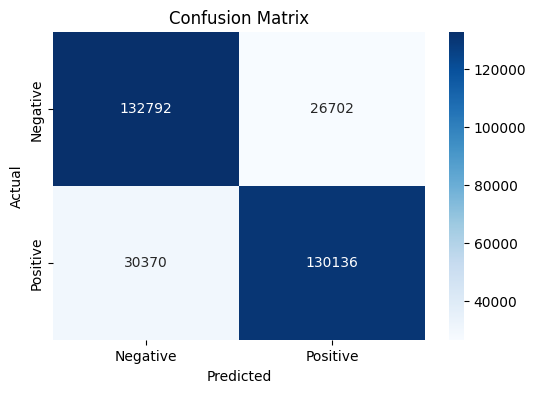

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
